In [319]:
%matplotlib inline
import seaborn
plt.style.use('seaborn')#switch to seaborn style# TODO
seaborn.set_style(style='white')

In [1]:
#import libraries
import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [95]:
tracks = pd.read_csv('data/tracks.csv', index_col=0, header=[0, 1]);
#load and normalize features
features= pd.read_csv('data/features.csv', index_col=0, header=[0, 1, 2])
dfmax=abs(features).max()
features=features.divide(dfmax)

genres=pd.read_csv('data/genres.csv', index_col=0, header=[0])


In [96]:
# Keep only the genre for each track
label=pd.DataFrame({('label','genre','main'): tracks['track']['genre_top'],
                    ('label','genre','sub'): tracks['track']['genres']})

label['label']['genre']
# Keep only the genres we want
genre_list = ['Hip-Hop', 'Rock','Jazz','Classical']#,'Pop','Electronic']
label = label[label['label']['genre']['main'].isin(genre_list)]

#add sub genres
genres_dict=genres['title'].to_dict()
genres_dict={str(key):genres_dict[key] for key in genres_dict}

label['label']['genre']['sub']=label['label']['genre']['sub'].str.replace('[^0-9| ]','').str.split(' ').apply(lambda x:'|'.join([genres_dict[k] for k in x ]))


# Merging
dataSet = features.merge(label, left_index=True, right_on='track_id')
#dataSet=dataSet.sort_values([('label', 'genre','main')])


In [7]:
#we calculate the distances of our dataset
distances = pdist(dataSet.drop(columns='label',level=0).values, metric='euclidean')

In [8]:
#We calculate the weights of our adjacency matrix
kernel_width = distances.mean()
weights = np.exp(-distances**2 / kernel_width**2)
adjacency_full = squareform(weights)

In [11]:
np.save("data/adjacency_HRJC.npy",adjacency_full)

In [4]:
adjacency_full=np.load("data/adjacency_HRJC.npy")

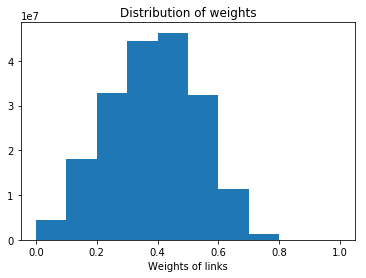

In [12]:
# plt.hist(weights)
# plt.title('Distribution of weights')
# plt.xlabel('Weights of links')
# plt.show()

In [56]:
#informatons over connectivity of main component
adjacency=adjacency_full.copy() #we keep the original adjacency matrix
adjacency[adjacency < 0.7] = 0
graph=nx.from_numpy_matrix(adjacency)
print("#nodes= ",adjacency.shape[0])
print("#compo= ",nx.number_connected_components(graph))
list_comp=sorted(nx.connected_components(graph), key = len, reverse=True)
print("#nodes in giant component= ", len(list_comp[0]))
print("percentage of nodes in main component= ",len(list_comp[0])/adjacency.shape[0])

#nodes=  19535
#compo=  4211
#nodes in giant component=  14952
percentage of node in main component=  0.7653954440747377


In [173]:
#keep only the main component and corresponding label
conn_graph = list(nx.connected_component_subgraphs(graph))[0]
conn_label=label.iloc[list(list_comp[0])]

## Graph plot##

In [142]:
laplacian=nx.laplacian_matrix(conn_graph)

In [220]:
label=np.array(conn_label.label.genre.main)
label_num=label.copy()
label_num[label_num=='Hip-Hop']=-1
label_num[label_num=='Rock']=-0.3333
label_num[label_num=='Jazz']=0.3333
label_num[label_num=='Classical']=1
label_num

array([-1, -1, -1, ..., -0.3333, -0.3333, -0.3333], dtype=object)

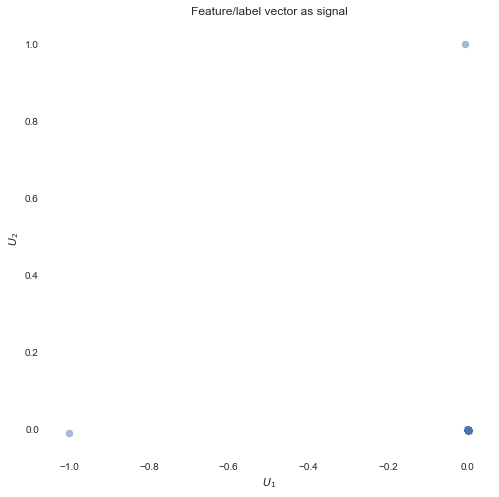

In [292]:
plt.figure(figsize=(8, 8))

plt.scatter(eigenvectors[:, 2], eigenvectors[:, 1], alpha=0.5, cmap='coolwarm')
plt.title('Feature/label vector as signal')
plt.xlabel('$U_1$')
plt.ylabel('$U_2$')
plt.show()

In [323]:
e,eigenvectors = scipy.sparse.linalg.eigs(laplacian,k=6)

e=e.real
eigenvectors=eigenvectors.real

coords = nx.spring_layout(conn_graph)  # Force-directed layout.
# coords = eigenvectors[:, [1,2]]  # Laplacian eigenmaps.
nx.draw_networkx_nodes(conn_graph, coords)
# nx.draw_networkx_edges(graph, coords, alpha=0.3)

In [321]:
np.save('data/coords_HRJC',coords)

C:\Users\joachim\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


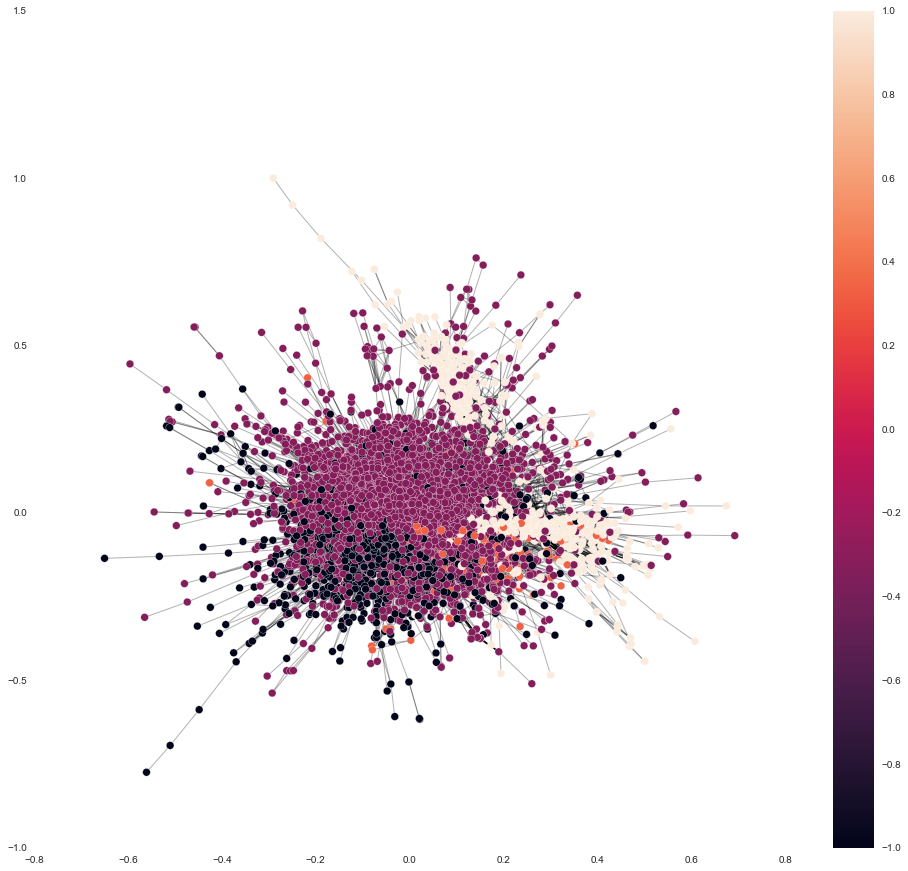

In [324]:
plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(conn_graph, coords,node_size=60, node_color=label_num)
nx.draw_networkx_edges(conn_graph, coords, alpha=0.3)
sm = plt.cm.ScalarMappable( norm=plt.Normalize(vmin=-1, vmax=1))
sm._A = []
plt.colorbar(sm)
plt.show()

In [400]:
# tmp=conn_graph.copy();
G = nx.Graph()
pos = {0:'Hip-Hop',1: 'Rock'}
G.add_node(0)
G.add_node(1)
nx.set_node_attributes(G, values=pos, name="coords")
G.nodes[1]["coords"]

'Rock'

In [417]:
tmp_label=list(np.array(conn_label.label.genre.main))
label_dict={ i : tmp_label[i] for i in range(0, len(tmp_label) ) }
nx.set_node_attributes(conn_graph, values=label_dict, name="genre")

In [446]:
import random
subnode=random.sample(list(conn_graph.node), 5000)
sub_graph=conn_graph.subgraph(subnode)
nx.write_gexf(sub_graph, "data/graph_HRJC_5k.gexf")

# personal tests

In [14]:
dataSet

feature      chroma_cens                                                    \
statistics      kurtosis                                                     
number                01        02        03        04        05        06   
track_id                                                                     
2           8.119817e-04  0.001826  0.000140  0.000317  0.000465  0.000189   
3           2.136023e-04  0.000266  0.000194  0.000539  0.000519  0.000024   
5           5.965635e-05 -0.000027 -0.000157  0.000161  0.000608  0.000313   
134         1.038569e-04  0.000235  0.000325  0.000301  0.000293  0.000028   
135         1.106368e-04  0.000218  0.000635 -0.000245 -0.000354 -0.000012   
136         1.034674e-04 -0.000225 -0.000259 -0.000125 -0.000114 -0.000081   
144         1.370595e-05 -0.000009  0.000305  0.000227  0.000340  0.000596   
145         1.078836e-04  0.000110  0.000009 -0.000006  0.000027  0.000455   
146        -8.635994e-05 -0.000119 -0.000154  0.000171 -0.000204  0.000039   
147         1.261730e-06  0.000024  0.000873 -0.000059  0.000050  0.000026   
151         3.030180e-04  0.000546  0.000916  0.000370  0.000772  0.001436   
152        -5.772206e-05  0.000576  0.000192  0.000091 -0.000117  0.000562   
153         2.756619e-04  0.000309  0.001631  0.000405  0.000392  0.000241   
154         4.573000e-03 -0.000088  0.000386 -0.000158 -0.000384  0.000454   
155         1.822776e-05  0.000552 -0.000113  0.000051  0.000062 -0.000158   
169        -5.581299e-06  0.000006 -0.000377  0.000110 -0.000071 -0.000045   
170        -4.861885e-05  0.000024  0.000516  0.000330  0.000479  0.000787   
171         1.486163e-04  0.000013 -0.000426 -0.000278 -0.000218  0.000070   
172         5.025282e-05 -0.000149  0.000390  0.000229  0.000056  0.000051   
173        -6.436932e-05 -0.000257 -0.000356 -0.000096 -0.000129 -0.000087   
174         1.420188e-04  0.000386  0.000594  0.000487  0.000839  0.000388   
175         2.850351e-04  0.000273  0.000414  0.000146  0.000133  0.000320   
176         9.490055e-05  0.001062  0.001580  0.000317 -0.000100  0.000419   
177        -2.153978e-05 -0.000116 -0.000186 -0.000040  0.000117  0.000149   
178        -8.194854e-05 -0.000149 -0.000065 -0.000114 -0.000186 -0.000330   
179         3.012795e-04  0.000401  0.004551  0.002051  0.000155  0.000447   
181        -2.272684e-05 -0.000105  0.000477  0.000034  0.000114 -0.000002   
182         3.396350e-05  0.000376 -0.000262  0.000034 -0.000098  0.000406   
183         2.330360e-04  0.000882  0.000103 -0.000114 -0.000249 -0.000277   
184         4.534746e-05  0.000097 -0.000247 -0.000164 -0.000170 -0.000153   
...                  ...       ...       ...       ...       ...       ...   
154743      5.297149e-05 -0.000218 -0.000376 -0.000117 -0.000251  0.000380   
154744     -7.705453e-05 -0.000174  0.000304 -0.000144 -0.000160 -0.000081   
154745     -1.112975e-04 -0.000281 -0.000393 -0.000020 -0.000305 -0.000095   
154746     -9.576647e-05 -0.000244 -0.000114  0.000071 -0.000059  0.000498   
154747     -2.372291e-05 -0.000351 -0.000362 -0.000152 -0.000212 -0.000198   
154853      7.355635e-05  0.000043  0.000084 -0.000018 -0.000079  0.000187   
154919     -1.165313e-04 -0.000335  0.002282 -0.000403 -0.000493 -0.000536   
155033     -2.440109e-05  0.000203 -0.000077 -0.000101 -0.000063 -0.000137   
155034      1.763400e-04  0.000368  0.001112  0.000062  0.000157  0.000346   
155035      2.193374e-07 -0.000248 -0.000159  0.000078 -0.000134 -0.000044   
155036      8.957521e-05  0.000022  0.000457  0.000268  0.000230  0.000333   
155037      1.119774e-05  0.000077 -0.000012  0.000087 -0.000006  0.000120   
155038      2.654276e-05 -0.000104  0.000052  0.000293  0.002589  0.001579   
155039     -2.644857e-05 -0.000211  0.000096 -0.000175 -0.000212 -0.000178   
155040      7.340680e-05  0.000225  0.000535  0.000031 -0.000095  0.000050   
155063      5.224100e-05 -0.000193 -0.000220  0.000154 -0.000230 -0.000053   
155064     -1.931852e-

In [51]:
genre_top=genres[genres['parent']==0]
genre_top

,#tracks,parent,title,top_level
genre_id,,,,
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5
8,868,0,Old-Time / Historic,8
9,1987,0,Country,9
10,13845,0,Pop,10
12,32923,0,Rock,12
13,730,0,Easy Listening,13


In [125]:
tracks_raw = pd.read_csv('../data/fma_metadata/raw_tracks.csv', index_col=0);
tracks_raw['track_url'][2]

'http://freemusicarchive.org/music/AWOL/AWOL_-_A_Way_Of_Life/Food'

In [6]:
# find specific sample
samples=tracks[tracks['track']['genres']=='[15]']
samples_in_small=samples[samples['set']['subset'] == 'medium']
samples_in_small

album                                            \
         comments         date_created        date_released   
track_id                                                      
397             0  2009-01-07 11:04:01  2007-01-01 00:00:00   
398             0  2008-11-26 02:01:54  2005-07-05 00:00:00   
399             0  2008-11-26 02:01:54  2005-07-05 00:00:00   
400             0  2009-01-07 11:04:01  2007-01-01 00:00:00   
405             0  2008-11-26 02:01:54  2005-07-05 00:00:00   
414             0  2008-11-26 02:01:54  2005-07-05 00:00:00   
550             0  2008-11-26 02:08:19  2009-01-08 00:00:00   
664             0  2008-11-26 02:14:23  2002-10-01 00:00:00   
665             0  2009-01-08 12:05:17  2009-01-08 00:00:00   
878             0  2008-11-26 02:25:39  2009-01-08 00:00:00   
881             0  2008-11-26 02:25:52  2009-01-12 00:00:00   
889             0  2008-11-26 02:25:39  2009-01-08 00:00:00   
1085            0  2008-11-26 02:34:28  2003-01-20 00:00:00   
1086            0  2008-11-26 02:34:28  2003-01-20 00:00:00   
1088            0  2008-11-26 02:34:28  2003-01-20 00:00:00   
1089            0  2008-11-26 02:34:28  2003-01-20 00:00:00   
1121            0  2008-11-26 02:38:27  2009-01-14 00:00:00   
1339            0  2008-11-26 02:48:07  1995-01-01 00:00:00   
1481            0  2008-11-26 02:58:25  2007-01-01 00:00:00   
1483            0  2008-11-26 02:58:25  2007-01-01 00:00:00   
1485            0  2008-11-26 02:58:25  2007-01-01 00:00:00   
1486            0  2008-11-26 02:58:24  2009-01-16 00:00:00   
1634            0  2008-11-26 03:06:22  2006-01-01 00:00:00   
1635            0  2008-11-26 03:06:22  2006-01-01 00:00:00   
1638            0  2008-11-26 03:06:22  2006-01-01 00:00:00   
1640            0  2008-11-26 03:06:22  2006-01-01 00:00:00   
1677            0  2008-11-26 03:07:47  2009-01-23 00:00:00   
1678            0  2008-11-26 03:07:47  2009-01-23 00:00:00   
3268            0  2008-12-04 09:27:11  2008-09-29 00:00:00   
3452            0  2008-12-04 09:27:17  2008-10-14 00:00:00   
...           ...                  ...                  ...   
145800          0  2016-11-03 15:38:21                  NaN   
145801          0  2016-11-03 15:38:21                  NaN   
145802          0  2016-11-03 15:38:21                  NaN   
145803          0  2016-11-03 15:38:21                  NaN   
145804          0  2016-11-03 15:38:21                  NaN   
145805          0  2016-11-03 15:38:21                  NaN   
147919          0  2016-12-16 17:21:41                  NaN   
147920          0  2016-12-16 17:21:41                  NaN   
147921          0  2016-12-16 17:21:41                  NaN   
147922          0  2016-12-16 17:21:41                  NaN   
147923          0  2016-12-16 17:21:41                  NaN   
147924          0  2016-12-16 17:21:41                  NaN   
148960          0  2017-01-05 17:21:03  2017-01-06 00:00:00   
148961          0  2017-01-05 17:21:03  2017-01-06 00:00:00   
148962          0  2017-01-05 17:21:03  2017-01-06 00:00:00   
151026          0  2017-02-06 14:47:39  2016-06-11 00:00:00   
151654          0  2017-02-09 16:56:41  2013-08-09 00:00:00   
152317          0  2017-02-13 15:07:42  2011-09-16 00:00:00   
152318          0  2017-02-13 15:07:42  2011-09-16 00:00:00   
152319          0  2017-02-13 15:07:42  2011-09-16 00:00:00   
152322          0  2017-02-13 15:24:45  2011-11-04 00:00:00   
152323          0  2017-02-13 15:24:45  2011-11-04 00:00:00   
152546          0  2017-02-15 14:56:34                  NaN   
152550          0  2017-02-15 14:56:34                  NaN   
152552          0  2017-02-15 14:56:34                  NaN   
152553          0  2017-02-15 14:56:34                  NaN   
152554          0  2017-02-15 14:56:34                  NaN   
152704          0  2017-02-17 23:53:05  2005-10-16 00:00:00   
152720          0  2017-02-18 00:07:12  2007-12-27 00:00:00   
152721          0  2017-02-18 00:07:12  200

In [62]:
label['label']['genre']['main'].unique()

array(['Hip-Hop', 'Pop', 'Rock', 'Jazz', 'Classical'], dtype=object)